# Simple upscalling test for inversion with flopy 
Valentin Dall'alba 03/2020

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

### Some functions

In [2]:
def read_pickle(path):
    '''
    function to read a pickle file
    '''
    
    with open(path, 'rb')as file:
        f_read = pickle.load(file)
    
    return f_read

def write_pickle(path, file):
    '''
    function to write picke file
    '''
    
    with open(path,'wb')as f:
        pickle.dump(file, f, pickle.HIGHEST_PROTOCOL)
        

In [3]:
def assign_k(simu, facies_list, k_list):
    '''
    Function to assign permeability values to categ simulation.
    
    -------
    Input : 
    simu = np array from the simulation (ny,nx)
    facies_list = list of the categ facies number [0,1,2..]
    k_list = list of the permeability values for each facies [1e-2,1e-4...]
    
    -------
    Output:
    simu_k : np array (ny,nx) with the permeability values assigned
    '''
    
    simu_k = np.copy(simu)
    
    for f,k in zip(facies_list, k_list):
        
        krd = np.random.random(simu_k.shape)*k
        simu_k[simu_k==f] = krd[simu_k==f]
    
    return simu_k

In [4]:
def create_mask(grid):
    '''
    Create a mask from a define grid
    return a binary mask: 0 outside, 1 inside
    '''
    mask = np.ones(grid.shape)
    mask[np.isnan(grid)] = 0
    
    return mask

In [5]:
def up_simple_mean_array(arr, sx, sy, sx_up=1, sy_up=1):
    '''
    Function to upscall a np array (ny,nx) to a defined output resolution.
    
    -------
    Input:
    sx, sy : Dimension of the cells of the input grid.
    sx_up, sy_up : Dimension of the output upscalled cells.
    
    -------
    Output:
    array (ny,nx), upscalled grid with simple means.
    '''
    
    nx, ny = arr.shape[1], arr.shape[0]
    nx_up, ny_up = nx*sx/sx_up, ny*sy/sy_up
    sx_up, sy_up = sx_up, sy_up
    
    values = np.copy(arr) #[ny,nx]
    
    while nx_up/int(nx_up)!= 1.0:
        add_h  = np.full((values.shape[0],1), np.nan)
        values = np.hstack((values,add_h))
        nx     = values.shape[1]
        nx_up  = nx*sx/sx_up

    while ny_up/int(ny_up)!= 1.0:
        add_v  = np.full((1,values.shape[1]), np.nan) 
        values = np.vstack((values,add_v)) 
        ny     = values.shape[0]
        ny_up  = ny*sy/sy_up
    
    #Groups
    coord_x = np.arange(sx/2,nx*sx+sx/2,sx)
    coord_y = np.arange(sy/2,ny*sy+sy/2,sy)
    coords  = np.array([[co_x, co_y] for co_y in coord_y for co_x in coord_x])
    
    p_x = [int(np.trunc(cx/sx_up)) for cx in coords[:,0]]
    p_y = [int(np.trunc((cy/sy_up))*nx) for cy in coords[:,1]]
    p = np.array([[px+py] for px,py in zip(p_x,p_y)])
    
    groups = {}
    for i,pos in enumerate(p):
        if pos[0] in groups.keys():
            groups[pos[0]].append(i)
        else:
            groups[pos[0]] = []
            groups[pos[0]].append(i)

    #Means
    means = up_mean(groups, values, nx_up, ny_up)    
    print('The shape of the ouptut grid is {}'.format(means.shape))
    
    return means

In [6]:
def up_mean(groups, values, nx_up, ny_up):
    '''
    To perform a simple mean operation during upscalling.
    Used for the up_simple_mean_array function.
    '''
    
    means = np.full((int(nx_up*ny_up)),np.nan)
    
    for i, key in enumerate(groups.keys()):
        val_group = [values.flatten()[cell] for cell in groups[key]]
        means[i]  = (np.nanmean(val_group))
        
    return np.reshape(means,(int(ny_up),int(nx_up)))

### Import the simulation 
2D MPS simulations

nx, ny = 409, 512  
ox = 664328.1865  
oy = 6153000.2413  
sx, sy = 100, 100

In [7]:
pathsimu = 'simu.pickle'

In [8]:
simu = read_pickle(pathsimu)
simu = simu.val[0,0]
simu.shape

(512, 409)

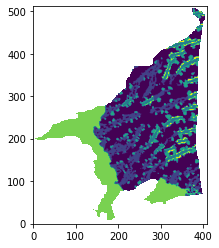

In [9]:
plt.imshow(simu, origin='lower',cmap='viridis')
plt.show()

### Assign facies properties

The simulation is composed of 5 facies:  
0 = plaine innondation  
1 = rivière en tresse  
2 = rivière en méandre  
3 = crevasse splay  
4 = cone alluvial  
5 = levee  

In [10]:
facies_list = [0,1,2,3,4,5]
k_list      = [1e-7,1e-4,1e-3,1e-4,5e-3,1e-6]
simu_k      = assign_k(simu, facies_list, k_list)

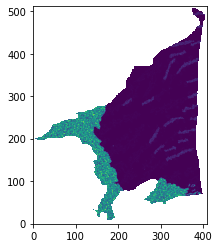

In [11]:
plt.imshow(simu_k, origin='lower',cmap='viridis')

### Upscalling to the flopy grid resolution

In [12]:
sx = 100
sy = 100
sx_up = 400
sy_up = 400
simu_up = up_simple_mean_array(simu_k, sx, sy, sx_up = sx_up, sy_up = sy_up)

/home/valentin/anaconda3/envs/these/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


The shape of the ouptut grid is (128, 103)


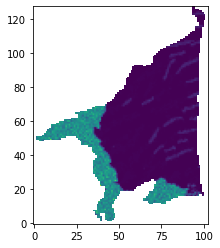

In [13]:
plt.imshow(simu_up,origin='lower')

### Once upscalled we can create a mask for the active cell (1) and non-active cell (0) for the new resolution

In [14]:
mask = create_mask(simu_up)

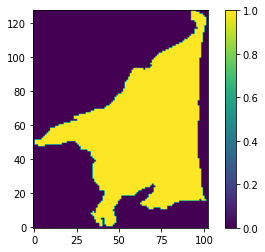

In [15]:
plt.imshow(mask, origin='lower')
plt.colorbar()

### We can export the grid and mask

In [16]:
write_pickle('export_up.pickle',[simu_up, mask])

### To do

Je pense qu'il faut maintenant automatiser l'import dans le script flopy le champ de permeabilité upscaller et le mask pour définir qu'elles sont les cellules actives ou non. (fichier export_up.pickle)  
Ensuite on run la simulation.  
On compare les résultats. On calcul un indice que l'on va chercher à minimiser.  
On modifie les valeurs de perméabilités de la simu, on re-upscalle les valeurs et on recommence la simu...  